In [2]:
import os
import numpy as np
import xarray as xr
import pandas as pd
from functools import partial
from joblib import Parallel, delayed
import multiprocessing
from pathos.multiprocessing import ProcessingPool as Pool
import matplotlib.pyplot as plt
from IPython.display import display
# Load the ncdf4 package
import netCDF4 as nc
import rasterio
from shapely.geometry import Point
import geopandas as gpd
from rasterio.transform import from_origin
from rasterio.features import rasterize
from rasterio.transform import from_bounds
import rasterio
from shapely.geometry import Point
import geopandas as gpd
from rasterio.transform import from_origin
from rasterio.features import rasterize
from rasterio.transform import from_bounds
import matplotlib.colors as colors
import datetime

## File path and settings

In [3]:
# Set the file paths
ncname_cdi = "/Users/sabinmaharjan/projects/python/do/static/file/cdi_1.nc"
ncname_rain = "/Users/sabinmaharjan/projects/python/do/static/file/2024.forecast.nc"
ncname_rain_final="/Users/sabinmaharjan/projects/python/do/static/file/2.nc"
# pd.set_option('display.max_rows',None)
# pd.set_option('display.max_columns',None)

# pd.set_option('display.precision',2)
# pd.set_option('display.float_format','{:.2f}'.format)


In [4]:
try:
   
    ds = xr.open_dataset(ncname_rain)

    # Rename 'lat' to 'latitude' and 'lon' to 'longitude'
    ds = ds.rename({'lat': 'latitude', 'lon': 'longitude'})

    # Assuming latitude and longitude variables are now named 'latitude' and 'longitude'
    # Round latitude and longitude values
    ds['latitude'] = ds['latitude'].astype('double')
    ds['longitude'] = ds['longitude'].astype('double')

    # Round latitude values to two decimal places
    ds['latitude'] = ds['latitude'].round(decimals=2)
    ds['longitude'] = ds['longitude'].round(decimals=2)

    # Save the modified dataset to a new NetCDF file
    ds.to_netcdf(ncname_rain_final)

    print("New file saved as:", ncname_rain_final)

except Exception as e:
    print("An error occurred:", e)

New file saved as: /Users/sabinmaharjan/projects/python/do/static/file/2.nc


## Reading CDI data and creating dataframe

In [5]:

# Open the first NetCDF file

ds1 = xr.open_dataset(ncname_cdi)
 
# Get longitude and latitude
lon = ds1["longitude"].values
lat = ds1["latitude"].values
 
# Get cdi
dname1 = "cdi"
cdi_array = ds1[dname1].values
 
# Get a single slice or layer
cdi_slice = cdi_array[:, :, 305]  # Assuming 305 is the index of the slice you want


cdi_vec = np.ravel(cdi_slice)
 
# Create DataFrame for cdi data
lon_grid, lat_grid = np.meshgrid(lon, lat)
cdi_df = pd.DataFrame({'lon': lon_grid.flatten(), 'lat': lat_grid.flatten(), 'cdi': cdi_vec})
cdi_df_crop=cdi_df.dropna()


print(cdi_slice.shape)
print(cdi_df.shape)
print(cdi_df_crop.shape)
print(cdi_df_crop.head(10))
# Open the second NetCDF file


(681, 841)
(572721, 3)
(273592, 3)
         lon    lat       cdi
7423  146.75 -43.60  0.115448
7425  146.85 -43.60  0.071008
7426  146.90 -43.60  0.059857
8262  146.65 -43.55  0.172624
8263  146.70 -43.55  0.104389
8264  146.75 -43.55  0.104263
8265  146.80 -43.55  0.044113
8266  146.85 -43.55  0.035788
9092  146.10 -43.50  0.080951
9094  146.20 -43.50  0.179985


In [6]:

ds2 = xr.open_dataset(ncname_rain_final)
 
# Get longitude and latitude
lon_r = ds2["longitude"].values
lat_r = ds2["latitude"].values
 
# Get rain
dname2 = "percentage_of_ensembles"
rain_array = ds2[dname2].values
 
nbins=2
time=1
# Get slices
rain_slice = rain_array[nbins-1,time-1,:,:]
rain_vec = np.ravel(rain_slice)
 
# Create DataFrame for rain data
lon_grid, lat_grid = np.meshgrid(lon_r, lat_r)

rain_df = pd.DataFrame({'lat': lat_grid.flatten(), 'lon': lon_grid.flatten(), 'rain': rain_vec})

# rain_df= rain_df.replace(np.nan, 'NA', regex=True)

time_r = ds2["time"][time-1].values


# Convert the time value to a datetime object
time_r = pd.to_datetime(time_r)


# Extract the month name from the datetime object

month_name = time_r.strftime('%B')
print(rain_slice.shape)
print(rain_df.shape)

print("First month:", month_name)
rain_df_crop=rain_df.dropna()
print(rain_df_crop.head(10))
print(rain_df_crop.shape)


(691, 886)
(612226, 3)
First month: April
         lat     lon       rain
15756 -43.65  146.70  44.444443
15757 -43.65  146.75  44.444443
15759 -43.65  146.85  44.444443
16635 -43.60  146.35  44.444443
16641 -43.60  146.65  44.444443
16642 -43.60  146.70  44.444443
16643 -43.60  146.75  45.454544
16644 -43.60  146.80  45.454544
16645 -43.60  146.85  45.454544
16646 -43.60  146.90  44.444443
(281760, 3)


## merging CDI and forecast using lat and lon

In [7]:

# Perform the merge
join_df = cdi_df.merge(rain_df, how='left', on=['lon', 'lat'])
# Merge DataFrames on longitude and latitude
print(join_df.shape)
# join_dims={"lon":"lon","lat":"lat"}
# tes=xr.merge([cdi_df,rain_df],join='left',compat="override")
print("join_df.head(10)")
display(join_df)
# Count the number of rows with NaN values
num_rows_with_nan = join_df.isna().sum().sum()

# Count the number of rows without NaN values
num_rows_without_nan = join_df.notna().sum().sum()

print(f"Number of rows with NaN values: {num_rows_with_nan}")
print(f"Number of rows without NaN values: {num_rows_without_nan}")

rmna_df=join_df.dropna()
print(rmna_df.shape)
nan_count = rmna_df.isna().sum().sum()
nan__cdi_count = rmna_df.notna().sum().sum()
nan__cdi_count = rmna_df.notna().sum()
print("Number of  NaN values:", nan_count)
print("Number of NaN values:", nan__cdi_count)



(572721, 4)
join_df.head(10)


,lon,lat,cdi,rain
0,112.00,-44.0,NaN,NaN
1,112.05,-44.0,NaN,NaN
2,112.10,-44.0,NaN,NaN
3,112.15,-44.0,NaN,NaN
4,112.20,-44.0,NaN,NaN
...,...,...,...,...
572716,153.80,-10.0,NaN,NaN
572717,153.85,-10.0,NaN,NaN
572718,153.90,-10.0,NaN,NaN
572719,153.95,-10.0,NaN,NaN


Number of rows with NaN values: 590090
Number of rows without NaN values: 1700794
(273592, 4)
Number of  NaN values: 0
Number of NaN values: lon     273592
lat     273592
cdi     273592
rain    273592
dtype: int64


In [8]:
# import pandas as pd

# # Create sample DataFrames
# cdi_df = pd.DataFrame({
#     'lon': [1, 2, 3, 4, 5],
#     'lat': [10, 20, 30, 40, 50],
#     'cdi_val': [1.1, 2.2, 3.3, 4.4, 5.5]
# })

# rain_df = pd.DataFrame({
#     'lon': [2, 3, 4, 6],
#     'lat': [20, 30, 40, 60],
#     'rain_val': [100, 200, 300, 400]
# })

# # Perform left join
# join_df_py = pd.merge(cdi_df, rain_df, how='left', on=['lon', 'lat'])

# # Print the joined DataFrame
# print(join_df_py)

In [9]:
def classify_drought(row):
    cdi, rain = row['cdi'], row['rain']
    if cdi < 0.2:
        if rain < 50:
            if cdi < 0.02:
                return 5  # Persists
            else:
                return 6  # Worsens
        elif rain < 70:
            return 5  # Persists
        else:
            if 0.1 <= cdi < 0.2:
                return 2  # Removed
            else:
                return 3  # Improved
    else:
        if rain < 30:
            return 4  # Develops
        else:
            return 1  # No drought

In [10]:
ncell = len(rmna_df)

ncores = min(multiprocessing.cpu_count(), 4) 
# Use pathos for multiprocessing
with Pool(ncores) as p:
    try:
        classified = p.map(classify_drought, [rmna_df.iloc[i] for i in range(rmna_df.shape[0])])
    except Exception as e:
        print(f"An error occurred during multiprocessing: {e}")
        p.close() # Close the pool
        p.join() # Wait for the worker processes to exit
        raise # Re-raise the exception

print(len(classified))

273592


In [11]:
# Create the dataframe df_out
df_out = pd.DataFrame({ 'lat': cdi_df['lat'], 'lon': cdi_df['lon'],'outlook': np.nan })
print(len(rmna_df.index))

# Get the rows where NAs were removed
order = rmna_df.index.astype(int)


# Replace the category value
classified = np.array(classified)
df_out.loc[order, 'outlook'] = classified
print(df_out.dtypes)

print(df_out['outlook'].value_counts())
outlook_counts = df_out['outlook'].value_counts()
for value in range(1, 7):
    if value in outlook_counts:
        print(f"Value {value}: {outlook_counts[value]}")
    else:
        print(f"Value {value}: 0")


273592
lat        float64
lon        float64
outlook    float64
dtype: object
4.0    140277
1.0    115669
6.0     15918
5.0      1728
Name: outlook, dtype: int64
Value 1: 115669
Value 2: 0
Value 3: 0
Value 4: 140277
Value 5: 1728
Value 6: 15918


In [14]:
# Create a GeoDataFrame from the df_out DataFrame
geometry = [Point(xy) for xy in zip(df_out.lon, df_out.lat)]
gdf = gpd.GeoDataFrame(df_out, geometry=geometry, crs="EPSG:3577")

# Rasterize the GeoDataFrame
transform = rasterio.transform.from_bounds(*gdf.total_bounds, 681,841)
out_shape = (681,841)
out_raster = rasterize(
    [(geom, value) for geom, value in zip(gdf.geometry, gdf['outlook'])],
    out_shape=out_shape,
    transform=transform,
    fill=0,
    all_touched=True,
    dtype=rasterio.float32
)

# Create a DataArray from the rasterized data
da = xr.DataArray(out_raster,
                  coords=[('lat', lat), ('lon', lon)],
                  name='outlook')

# Add attributes to the DataArray 
da.attrs['varunit'] = ''
da.attrs['longname'] = 'drought outlook'

# Create a Dataset from the DataArray
ds = da.to_dataset()

# Add the time variable to the Dataset
current_time = datetime.datetime.now()
ds['time'] = (('time'), [current_time])

# Save the Dataset as a NetCDF file
out_ncname = "/Users/sabinmaharjan/projects/python/do/static/result/nc/1_months/"+month_name+"_Final_2024.nc"

try:
    ds.to_netcdf(out_ncname)
    print(f"file saved with name: {out_ncname}")
except Exception as e:
    print(f"An error occurred while saving the Dataset: {e}")

file saved with name: /Users/sabinmaharjan/projects/python/do/static/result/nc/1_months/April_Final_2024.nc


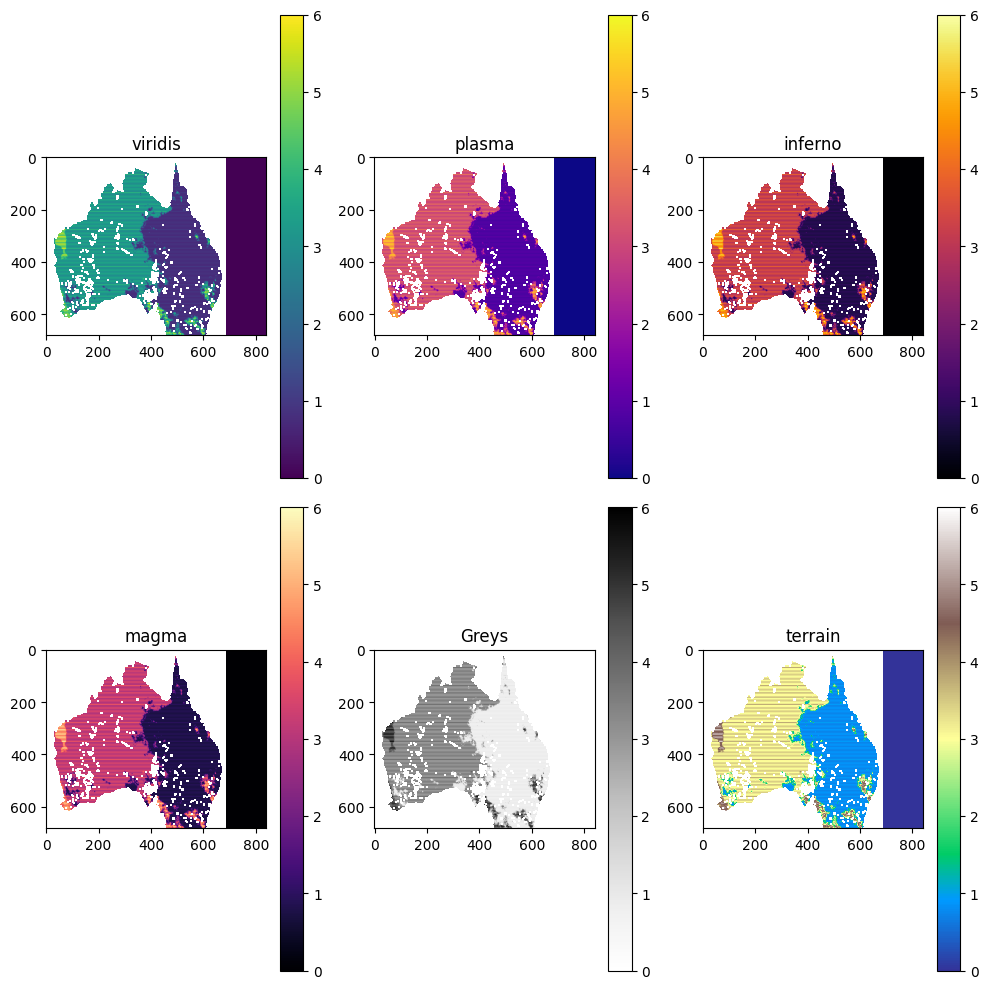

In [15]:
import matplotlib.pyplot as plt

# Display the raster with different colormaps
plt.figure(figsize=(10, 10))
# 'viridis' colormap (default)
plt.subplot(2, 3, 1)
plt.imshow(out_raster, cmap='viridis')
plt.title('viridis')
plt.colorbar()

# 'plasma' colormap
plt.subplot(2, 3, 2)
plt.imshow(out_raster, cmap='plasma')
plt.title('plasma')
plt.colorbar()

# 'inferno' colormap
plt.subplot(2, 3, 3)
plt.imshow(out_raster, cmap='inferno')
plt.title('inferno')
plt.colorbar()

# 'magma' colormap
plt.subplot(2, 3, 4)
plt.imshow(out_raster, cmap='magma')
plt.title('magma')
plt.colorbar()

# 'Greys' colormap (grayscale)
plt.subplot(2, 3, 5)
plt.imshow(out_raster, cmap='Greys')
plt.title('Greys')
plt.colorbar()

# 'terrain' colormap
plt.subplot(2, 3, 6)
plt.imshow(out_raster, cmap='terrain')
plt.title('terrain')
plt.colorbar()

plt.tight_layout()
plt.show()

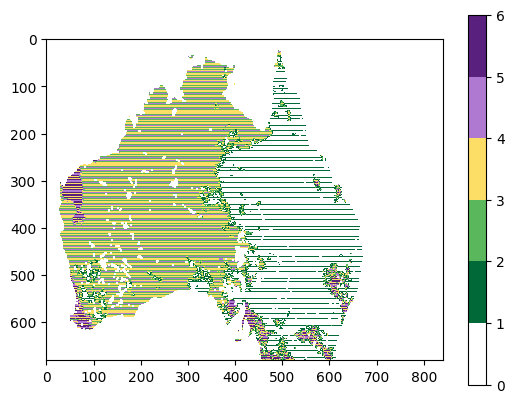

In [16]:
import matplotlib.colors as colors
cmap = colors.ListedColormap(['#FFFFFF', '#016838', '#5BB75B', '#FCDE66', '#B079D1', '#59207D'])
plt.imshow(out_raster, cmap=cmap)
plt.colorbar()
plt.show()

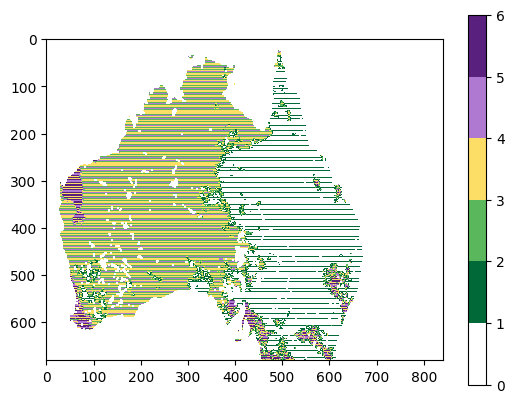

In [ ]:
import matplotlib.colors as colors
cmap = colors.ListedColormap(['#FFFFFF', '#016838', '#5BB75B', '#FCDE66', '#B079D1', '#59207D'])
plt.imshow(out_raster, cmap=cmap)
plt.colorbar()
plt.show()

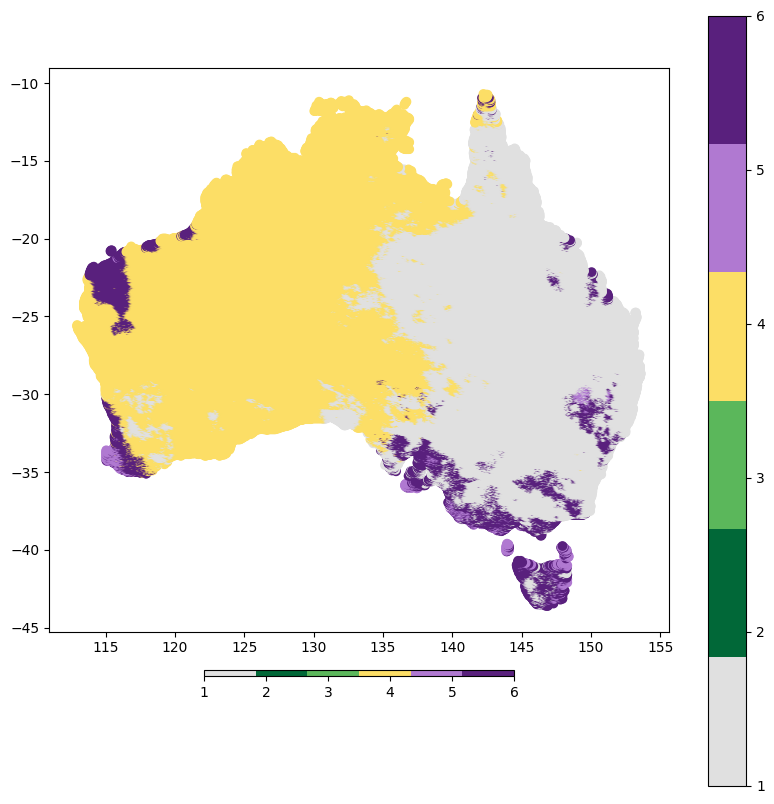

In [20]:
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

# Create a GeoDataFrame from the df_out DataFrame
geometry = [Point(xy) for xy in zip(df_out.lon, df_out.lat)]
gdf = gpd.GeoDataFrame(df_out, geometry=geometry, crs="EPSG:4326")

# Reproject to a different CRS (e.g., Australian Albers Equal Area)
gdf = gdf.to_crs("EPSG:4326")

# Plot the points on a map
fig, ax = plt.subplots(figsize=(10, 10))

cmap = colors.ListedColormap(['#E0E0E0', '#016838', '#5BB75B', '#FCDE66', '#B079D1', '#59207D'])

scatter = gdf.plot(column='outlook', cmap=cmap, legend=True, ax=ax)

# Create a mappable object from the scatter plot
mappable = scatter.collections[0]

# Add the colorbar
# plt.colorbar(mappable, ax=ax, orientation='horizontal', pad=0.05, aspect=50, shrink=0.5)

plt.show()

In [18]:
print(cdi_slice.shape)
print(len(lon))
print(len(lat))

(681, 841)
841
681


In [ ]:
# Create a DataArray from the DataFrame
da = xr.DataArray(df_out['outlook'].values.reshape(cdi_slice.shape),
                  coords=[('lat', lat),('lon', lon)],
                  name='outlook')

# da = xr.DataArray(df_out['outlook'].values, coords=[('lon', cdi_df['lon']), ('lat', cdi_df['lat'])], dims=['lon', 'lat'])

# Add attributes
da.attrs['varunit'] = ''
da.attrs['longname'] = 'drought outlook'

# Create a Dataset from the DataArray
ds = da.to_dataset()
# Add the time variable to the Dataset
ds['time'] = (('time'), [time_r])

In [ ]:
# Save the Dataset as a NetCDF file
out_ncname = "/Users/sabinmaharjan/projects/python/do/static/result/nc/1_months/"+month_name+"_Final_2024.nc"

try:
    ds.to_netcdf(out_ncname)
    print(f"file saved with name: {out_ncname}")
except Exception as e:
    print(f"An error occurred while saving the Dataset: {e}")

file saved with name: /Users/sabinmaharjan/projects/python/do/static/result/nc/1_months/April_Final_2024.nc
